In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()

In [7]:
benches = [ 'sieve' ]
# Alphabetical order
# pools = ['_async_fun', '_cc_fun', '_direct_fun', '_p2300_fun', '_tbb_fun']
# Performance order
pools = ['_cc_fun', '_tbb_fun', '_direct_fun', '_async_fun', '_p2300_fun']
sizes = [100000000, 1000000000]
blocks = [10, 100, 1000, 10000, 100000, 1000000 ]
blocks = [100]

In [ ]:
os.system('cd .. ; make clean ; make -j 8')

In [ ]:
for b in benches:
    for p in pools:
        os.system('/bin/rm -f ' + b + p + '.exe')
        os.system('cp ../' + b + p + '.exe .')

In [ ]:
for b in benches:
    for p in pools:
        bin = './' + b + p + '.exe'
        for s in sizes:
            for bl in blocks:
                if (p == '_seq' and bl != 1000000):
                    continue
                if (s >= bl*1000):
                    args = str(s) + ' ' + str(bl)
                    logfile = b + p + '_' + str(s) + '_' + str(bl) +'_out.txt'
                    os.system('/bin/rm -f ' + logfile)
                    for i in range(16):
                        os.system(bin + ' ' + args + ' >> ' + logfile)

In [8]:
for b in benches:
    for p in pools:
        for s in sizes:
            for bl in blocks:
                if (p == '_seq' and bl != 1000000):
                    continue
                if (s >= bl*1000):
                    listname = b + p + '_' + str(s) + '_' + str(bl)
                    exec(listname + ' = []')
                    logfile = b + p + '_' + str(s) + '_' + str(bl) +'_out.txt'
                    with open(logfile) as log:
                        lines = log.readlines()
                        for line in lines:
                            if 'Time using char' in line:
                                l = line.split(':')
                                num = int(l[1])
                                exec(listname + '.append(num)')
                    exec(listname + '_mean = np.mean(' + listname + ')')
                    exec(listname + '_std = np.std(' + listname + ')')


In [9]:
def time_vs_block_size(name, mean_times, std_times, blocks):
    fig, ax = plt.subplots(figsize=(16,9))
    x_pos = np.arange(len(blocks))
    ax.bar(x_pos, mean_times, yerr=std_times, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Run time')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(blocks, rotation= 90)
    ax.set_title('Sieve Performance Comparison: ' + name)
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    plt.savefig('bar_plot_' + name + '_.pdf')
    plt.show()

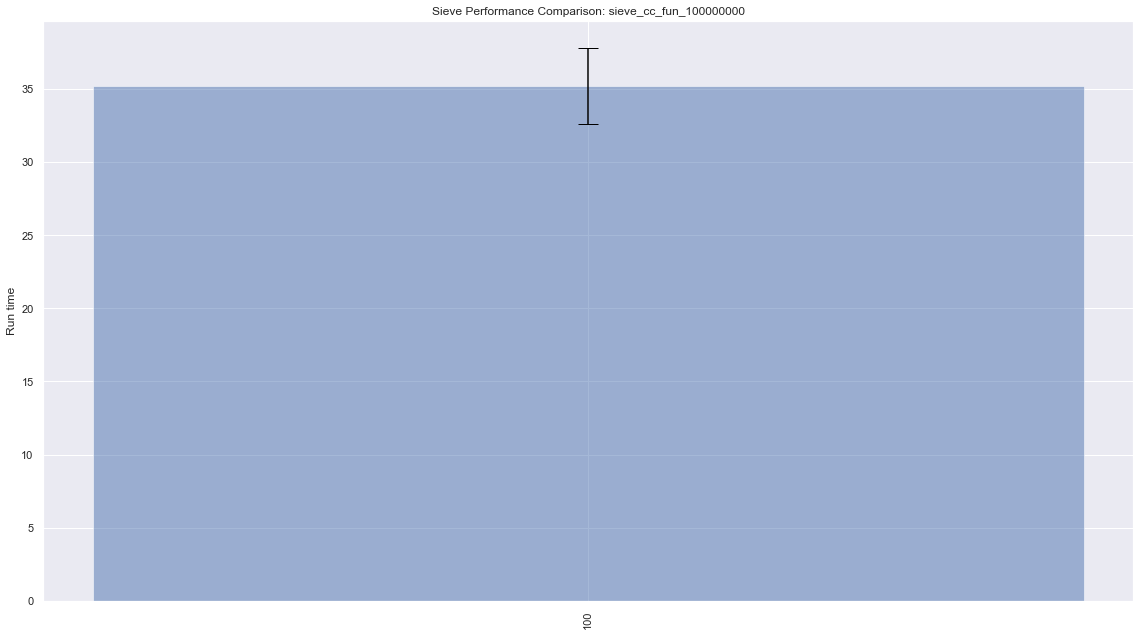

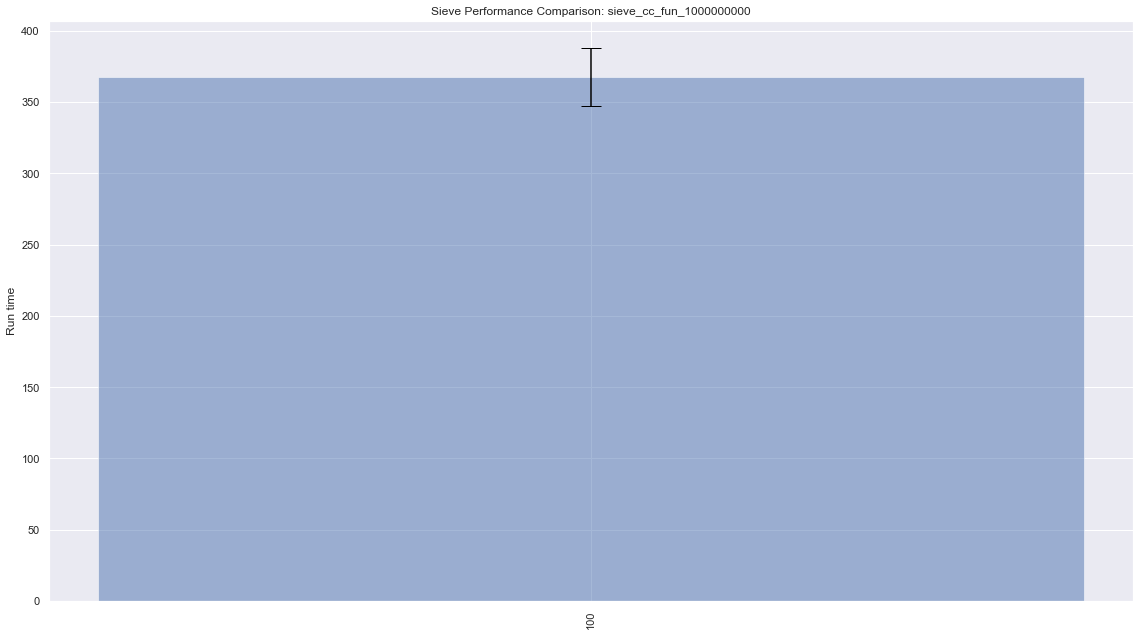

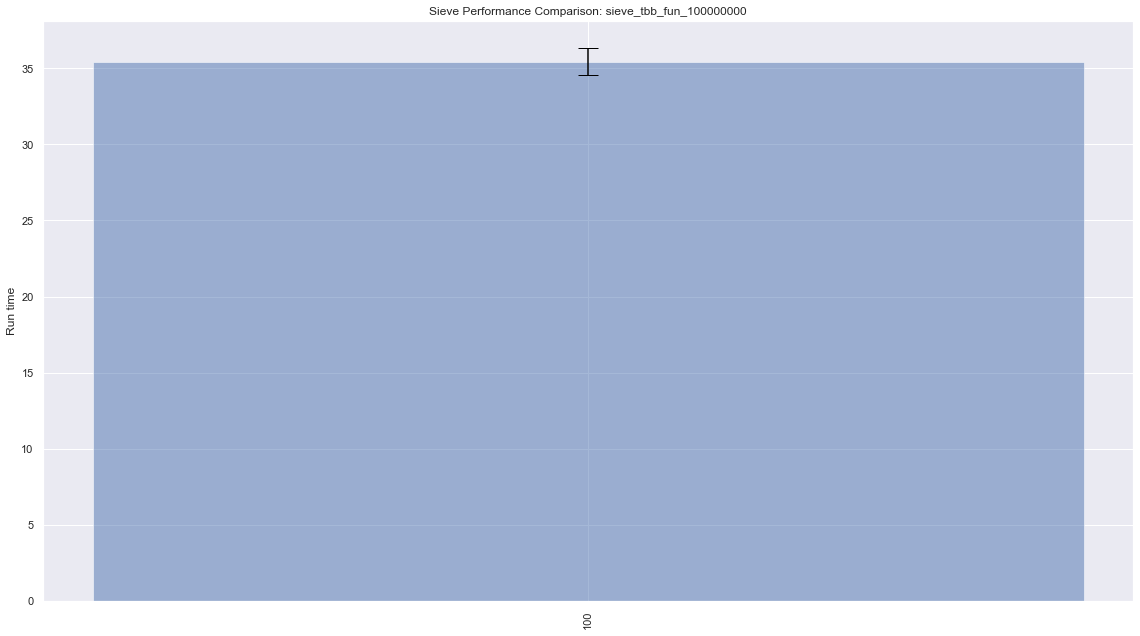

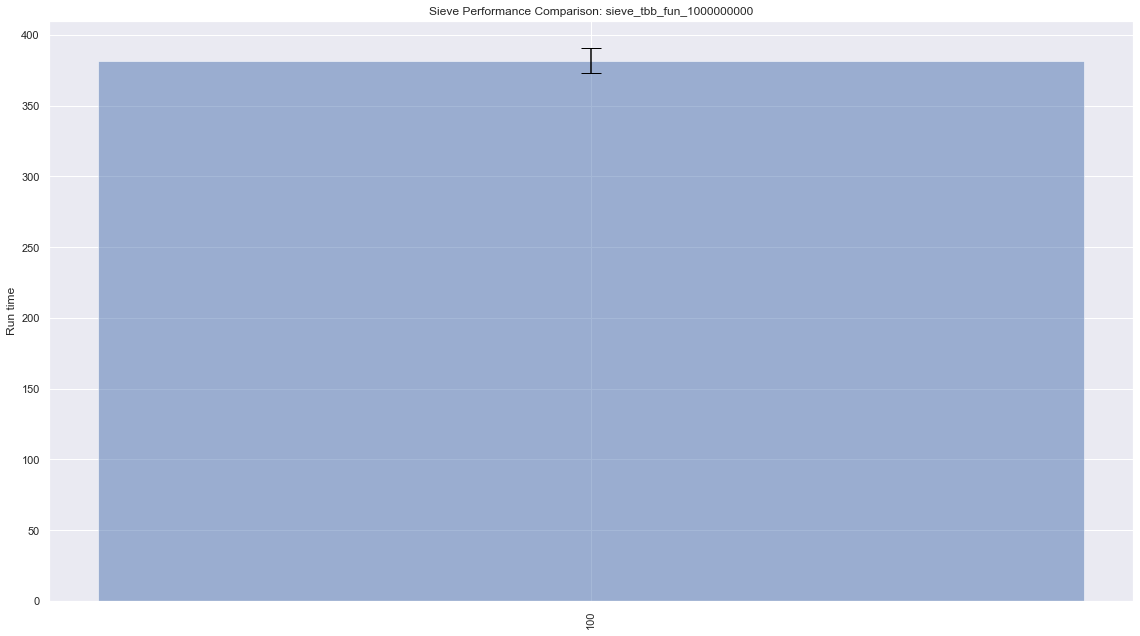

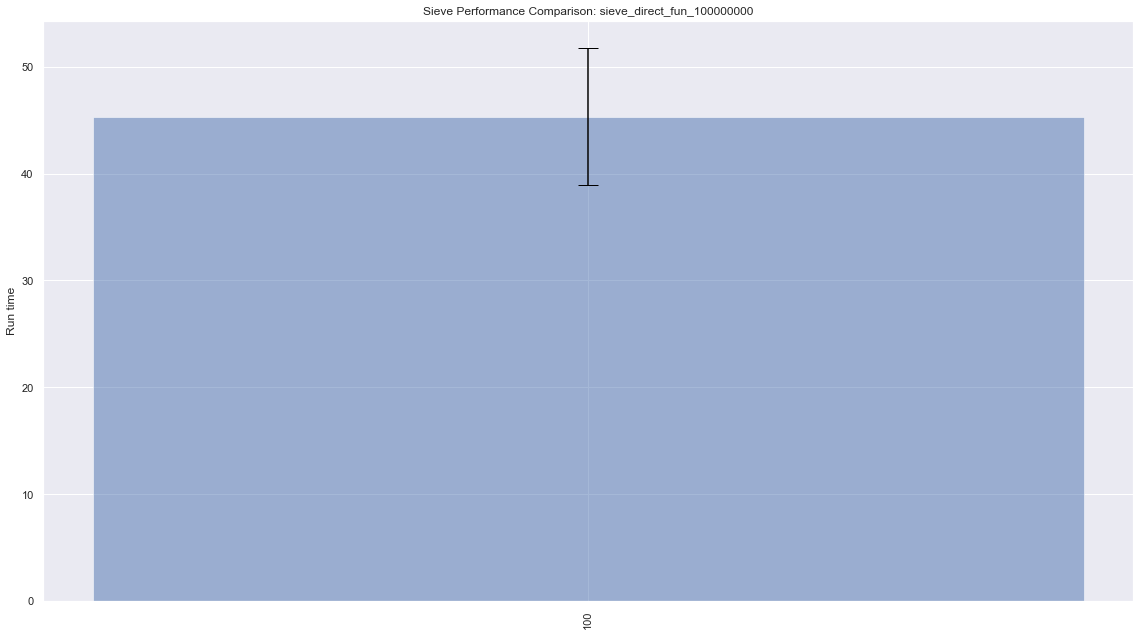

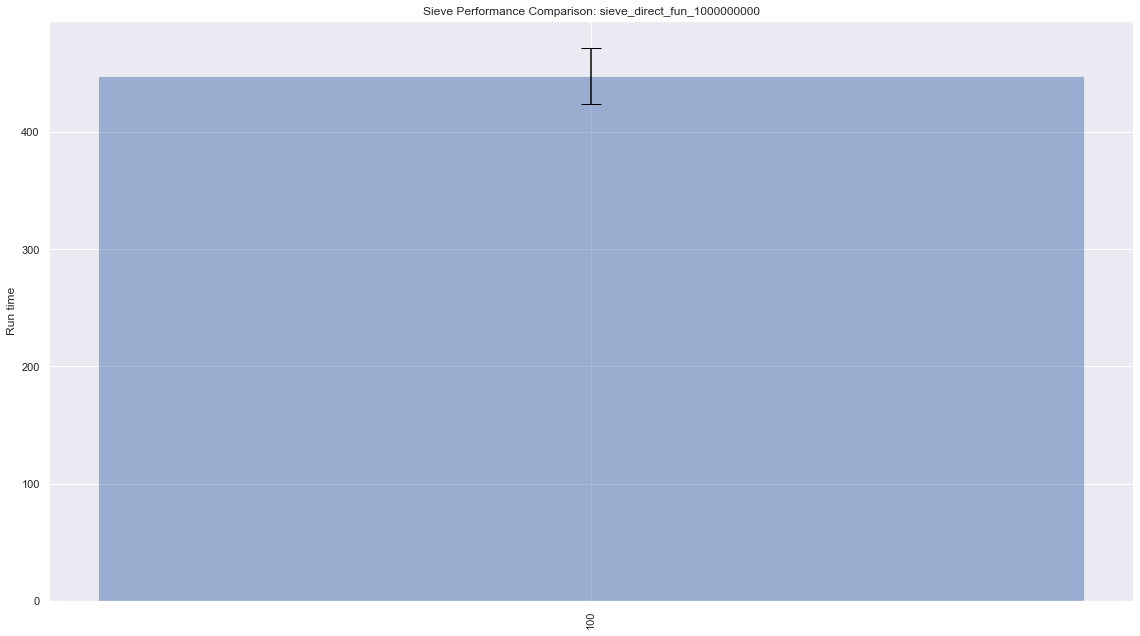

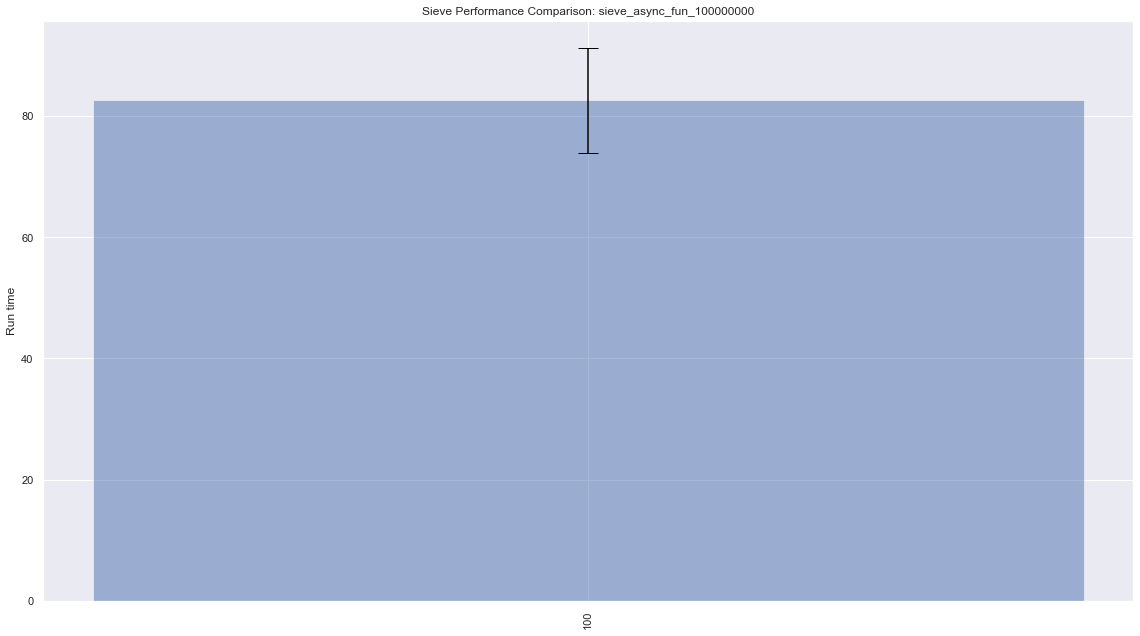

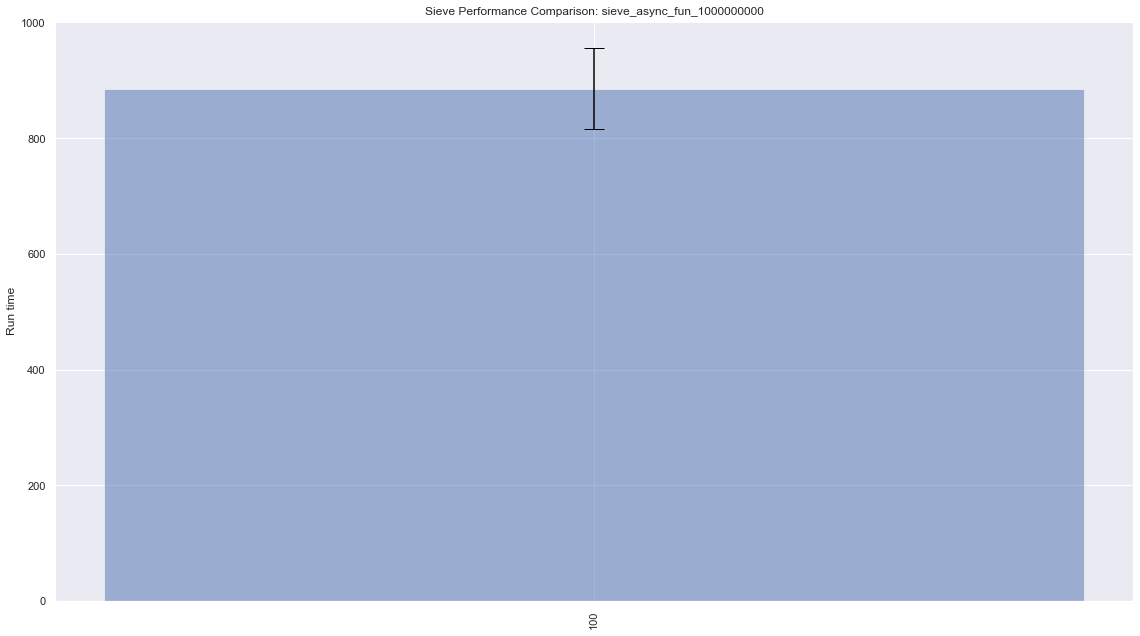

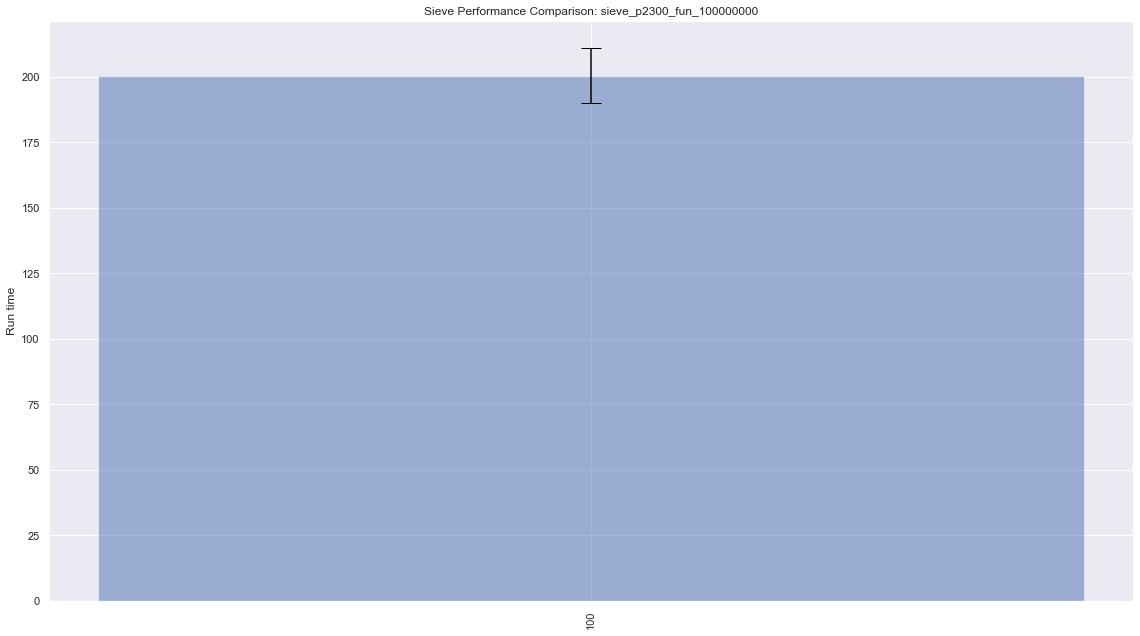

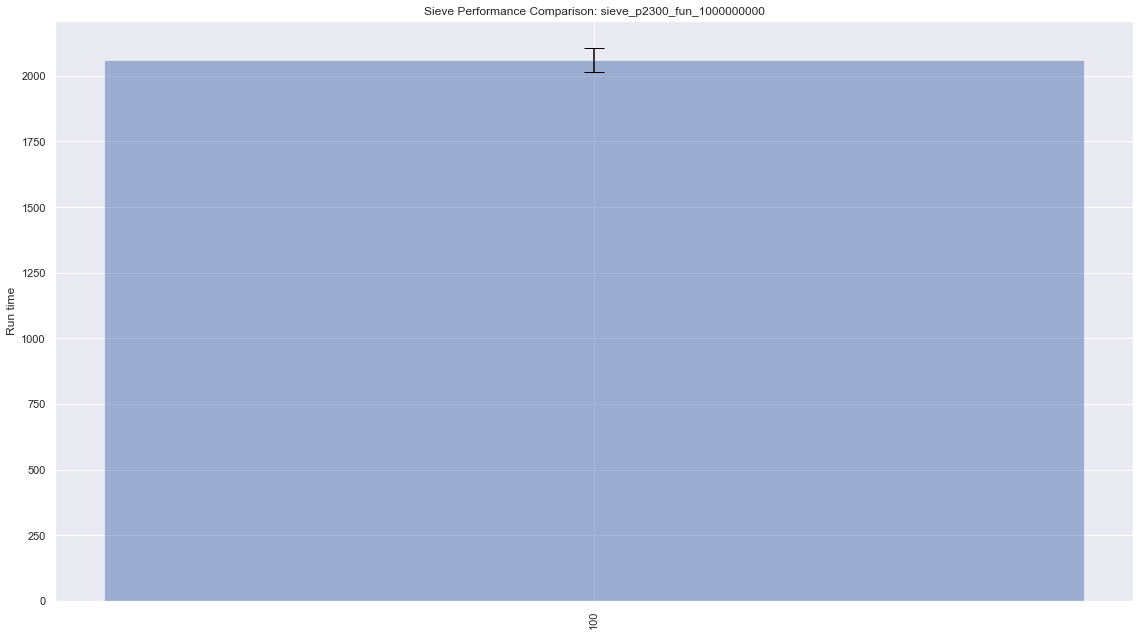

In [10]:
for b in benches:
    for p in pools:
        if (p == '_seq'):
            continue
        for s in sizes:
            listname = b + p + '_' + str(s)
            listname_mean = b + p + '_' + str(s) + '_mean'
            listname_std = b + p + '_' + str(s) + 'std'
            exec(listname_mean + ' = []')
            exec(listname_std + ' = []')
            xbl = []
            
            for bl in blocks:
                blockname_mean = b + p + '_' + str(s) + '_' + str(bl) + '_mean'
                blockname_std = b + p + '_' + str(s) + '_' + str(bl) + '_std'
                if (s >= bl*1000):
                    exec(listname_mean + '.append(' + blockname_mean + ')' )
                    exec(listname_std + '.append(' + blockname_std + ')' )
                    xbl.append(bl)
            exec('time_vs_block_size("' + listname + '", ' +listname_mean + ', ' + listname_std + ', ' + 'xbl)')
            

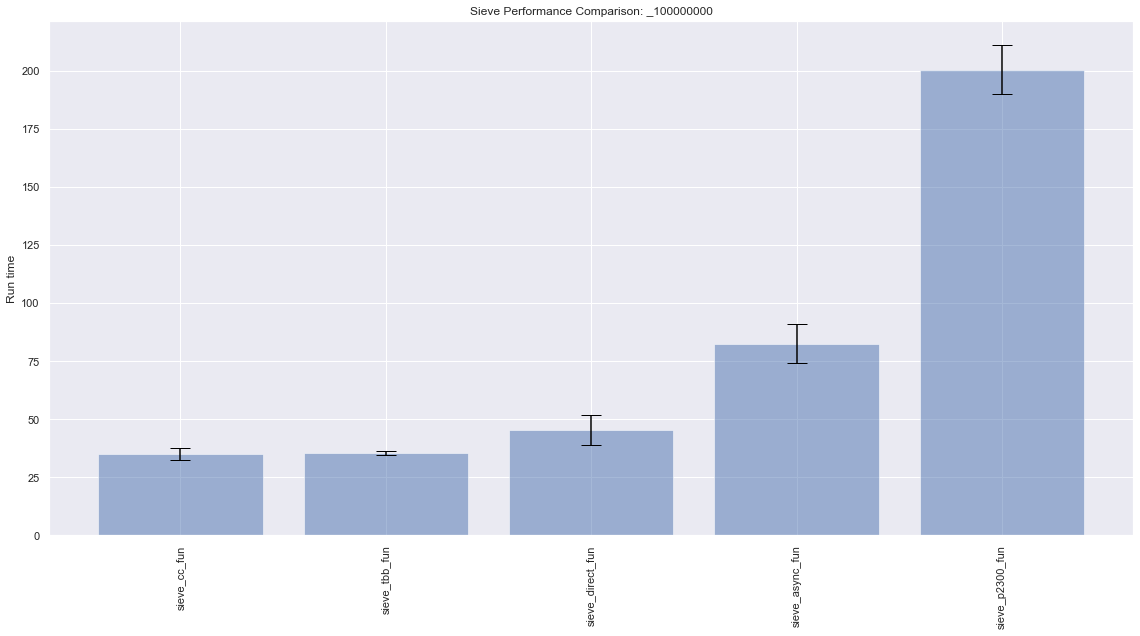

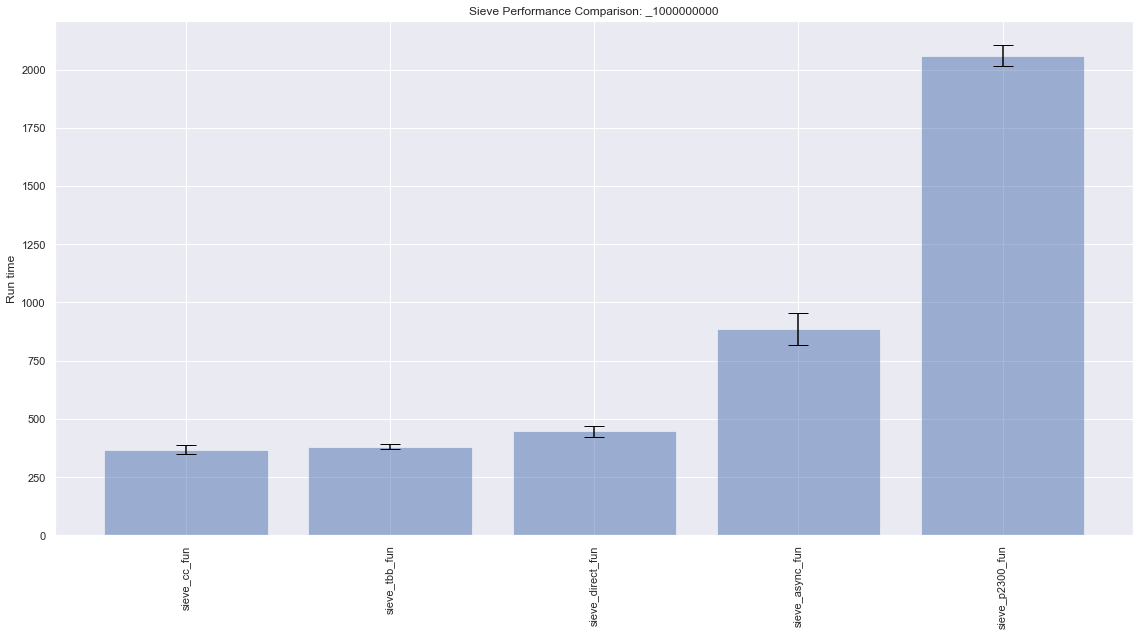

In [11]:
bl = 100
for s in sizes:
    
    listname = '_' + str(s)
    listname_mean = '_' + str(s) + '_mean'
    listname_std = '_' + str(s) + 'std'
    exec(listname_mean + ' = []')
    exec(listname_std + ' = []')
    xbl = []
    
    for b in benches:
        for p in pools:
            if (p == '_seq'):
                continue


            
            blockname_mean = b + p + '_' + str(s) + '_' + str(bl) + '_mean'
            blockname_std = b + p + '_' + str(s) + '_' + str(bl) + '_std'
            if (s >= bl*1000):
                exec(listname_mean + '.append(' + blockname_mean + ')' )
                exec(listname_std + '.append(' + blockname_std + ')' )
                xbl.append(b + p)
        exec('time_vs_block_size("' + listname + '", ' +listname_mean + ', ' + listname_std + ', ' + 'xbl)')